# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [194]:
# student 1:Vladislav 6999
# student 2:Lior 5078

## Part 2 - Initial Preparations 
You could add as many code cells as needed

### 2.1 Imports

In [195]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix


### 2.2 Loading the data

In [196]:
train = pd.read_csv("titanic_train.csv")
print("Train dataset:")
train.head()

Train dataset:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [197]:
test = pd.read_csv("titanic_test.csv")
print("\nTest dataset:")
test.head()


Test dataset:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


### 2.3 EDA

In [198]:
train.info()
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int64  
 7   Survived  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 44.6 KB
           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000   
mean     2.294944    0.640449   29.531213    0.528090    0.384831   32.379429   
std      0.841990    0.480206   13.188028    1.055052    0.803085   49.836074   
min      1.000000    0.000000    0.670000    0.000000    0.000000    0.000000   
25%      1.750000    0.000000   22.000000    0.000

#### Correlation Matrix and Diagram Passenger Class Distribution by Survival

Correlations of all features with 'Survived':
Pclass     -0.324024
Sex        -0.550699
Age        -0.072729
SibSp      -0.031052
Parch       0.074699
Fare        0.264345
Embarked    0.099162
Survived    1.000000
Name: Survived, dtype: float64


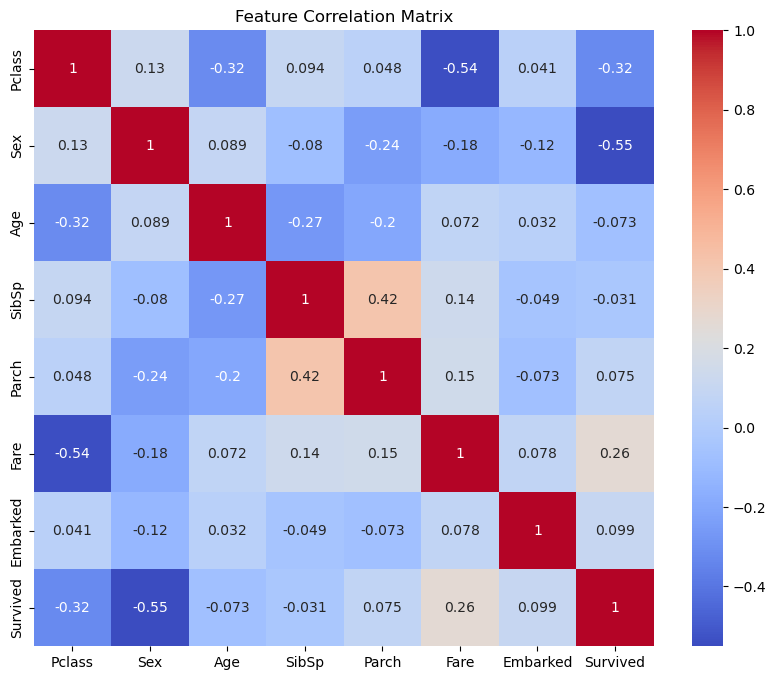

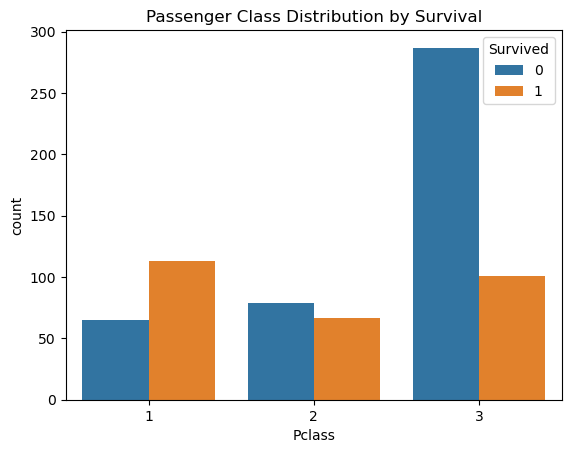

In [199]:
correlation_matrix = train.corr()

# Extract correlations relative to 'Survived'
survived_correlations = correlation_matrix['Survived']

# Print the correlation values between 'Survived' and all other features
print("Correlations of all features with 'Survived':")
print(survived_correlations)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()



# Visualizing survival based on Pclass
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title('Passenger Class Distribution by Survival')
plt.show()


#### Diagram of Number of Survivors by Gender

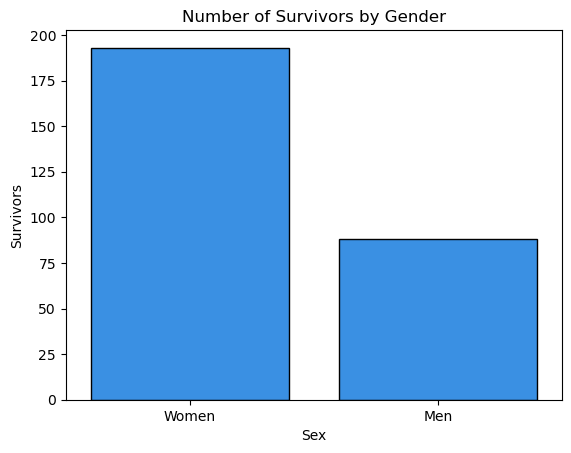

In [200]:
survived_counts = train.groupby('Sex')['Survived'].sum()

# הפיכת הסדר
survived_counts = survived_counts[::-1]

# בניית דיאגרמת עמודות
sns.barplot(x=survived_counts.index, y=survived_counts.values, color='dodgerblue', edgecolor='black')
plt.title('Number of Survivors by Gender')
plt.xlabel('Sex')
plt.ylabel('Survivors')
plt.xticks(ticks=[0, 1], labels=['Women', 'Men']) 
plt.show()

# 3.1 - 3.2 Feature Engineering

In [201]:
# Feature Engineering and Preprocessing
numerical_features = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']

#### Handling missing values and Scaling features

In [202]:
# Creating a Pieline to make several operations on the data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with median
    ('scaler', StandardScaler())  # Scale features
])

In [203]:
# Applying the preprocessing process on numerical_features (sending them to numerical_transfomer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)  # Apply preprocessing only to numerical features
    ])

## 3.3 Choosing the models
#### KNN - Algorithm that makes his decision based on K nearest neighbors.
#### Decision Tree - Algorithm that creates a tree that splits the data based on feature values.

In [204]:
# Create a pipeline for each model
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

pipeline_dtree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

#### Preparing the algorithms for GridSearch

In [205]:
# Define the hyperparameter space for GridSearchCV
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'], #Uniform = all neighbors have the same weight, Distance = the closer the neighbors the more weight
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev']  # Adding Euclidean, Manhattan, and Chebyshev metrics
}

param_grid_dtree = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

#### Preforming GridSearch and finding the best parameters and metrics

In [206]:
# Perform GridSearchCV
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='f1_macro') #finding the best possible parameter and metric for KNN
grid_search_dtree = GridSearchCV(pipeline_dtree, param_grid_dtree, cv=5, scoring='f1_macro') # Same for decision  tree

# 4. Training the models

#### Training our data based on the best parameters and metrics that we found from GridSearch

In [207]:
# Fit models using grid search
grid_search_knn.fit(train.drop('Survived', axis=1), train['Survived']) 
grid_search_dtree.fit(train.drop('Survived', axis=1), train['Survived'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Pclass',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='f1_macro')

#### Saving the best results and combination for the models

In [208]:
# Getting the best F1 scores and parameters for both models
best_f1_knn = grid_search_knn.best_score_
best_f1_dtree = grid_search_dtree.best_score_

best_params_knn = grid_search_knn.best_params_
best_params_dtree = grid_search_dtree.best_params_

#### Preparing to compare our results and choose the best model for testing

In [209]:
# Creating a DataFrame to compare the best scores and parameters
comparison_data = {
    'Model': ['KNN', 'Decision Tree'],
    'Best F1 Score': [best_f1_knn, best_f1_dtree],
    'Best Parameters': [best_params_knn, best_params_dtree]
}

comparison_df = pd.DataFrame(comparison_data)

#### Comparing both models and we can see that KNN got a better F1 score

In [210]:
# Display the comparison DataFrame
print("Comparison of Best F1 Scores and Parameters:")
print(comparison_df)

Comparison of Best F1 Scores and Parameters:
           Model  Best F1 Score  \
0            KNN       0.787705   
1  Decision Tree       0.772530   

                                     Best Parameters  
0  {'classifier__metric': 'euclidean', 'classifie...  
1  {'classifier__max_depth': 10, 'classifier__min...  


#### Saving the best model and it's parameters

In [211]:
# Part 4: Choose the best model and re-train it on the entire training dataset
best_model = grid_search_knn if grid_search_knn.best_score_ > grid_search_dtree.best_score_ else grid_search_dtree
print(f"Best model is: {'KNN' if best_model == grid_search_knn else 'Decision Tree'}")
print(f"Best parameters: {best_model.best_params_}")
print(f"Best F1 score: {best_model.best_score_}")

Best model is: KNN
Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best F1 score: 0.7877054613747905


In [212]:
# Re-train the selected best model on the entire training dataset
best_model = best_model.best_estimator_
best_model.fit(train.drop('Survived', axis=1), train['Survived'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Pclass',
                                                   'SibSp', 'Parch', 'Sex',
                                                   'Embarked'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])

# 5. Applying the best model on the test

In [213]:
# Part 5: Apply the best model to the test dataset
X_test = test.drop('Survived', axis=1)
y_test = test['Survived']
y_pred = best_model.predict(X_test)

#### Displaying the 5 first prediction of our model on the test

In [214]:
# Display the first 5 predictions vs actual labels
print("First 5 predictions from the best model:")
print(y_pred[:5])

First 5 predictions from the best model:
[0 0 0 1 1]


#### F1 score on the test 

In [215]:
# Calculate and display accuracy metrics
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score for the best model on Test Set: {f1}")

F1 Score for the best model on Test Set: 0.8272677143644885


#### Additonal information about the model

In [216]:
# Show classification report
print("\nClassification Report for the best model:")
print(classification_report(y_test, y_pred))


Classification Report for the best model:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       118
           1       0.76      0.79      0.77        61

    accuracy                           0.84       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

